In [113]:
!pip install transformers

In [114]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [115]:
import os

In [116]:
df_train=pd.read_csv('drive/My Drive/rotten2/train.tsv',delimiter='\t')
df_test=pd.read_csv('drive/My Drive/rotten2/test.tsv',delimiter='\t')

In [117]:
df_train.head(3)

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2


In [122]:
def relabel(label):
    label = int(label)
    if label < 2:
        return 0
    elif label == 2:
        return 1
    else:
        return 2

df_train['Sentiment'] = df_train['Sentiment'].apply(relabel)
df_train['Sentiment'].unique()

array([0, 1, 2])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


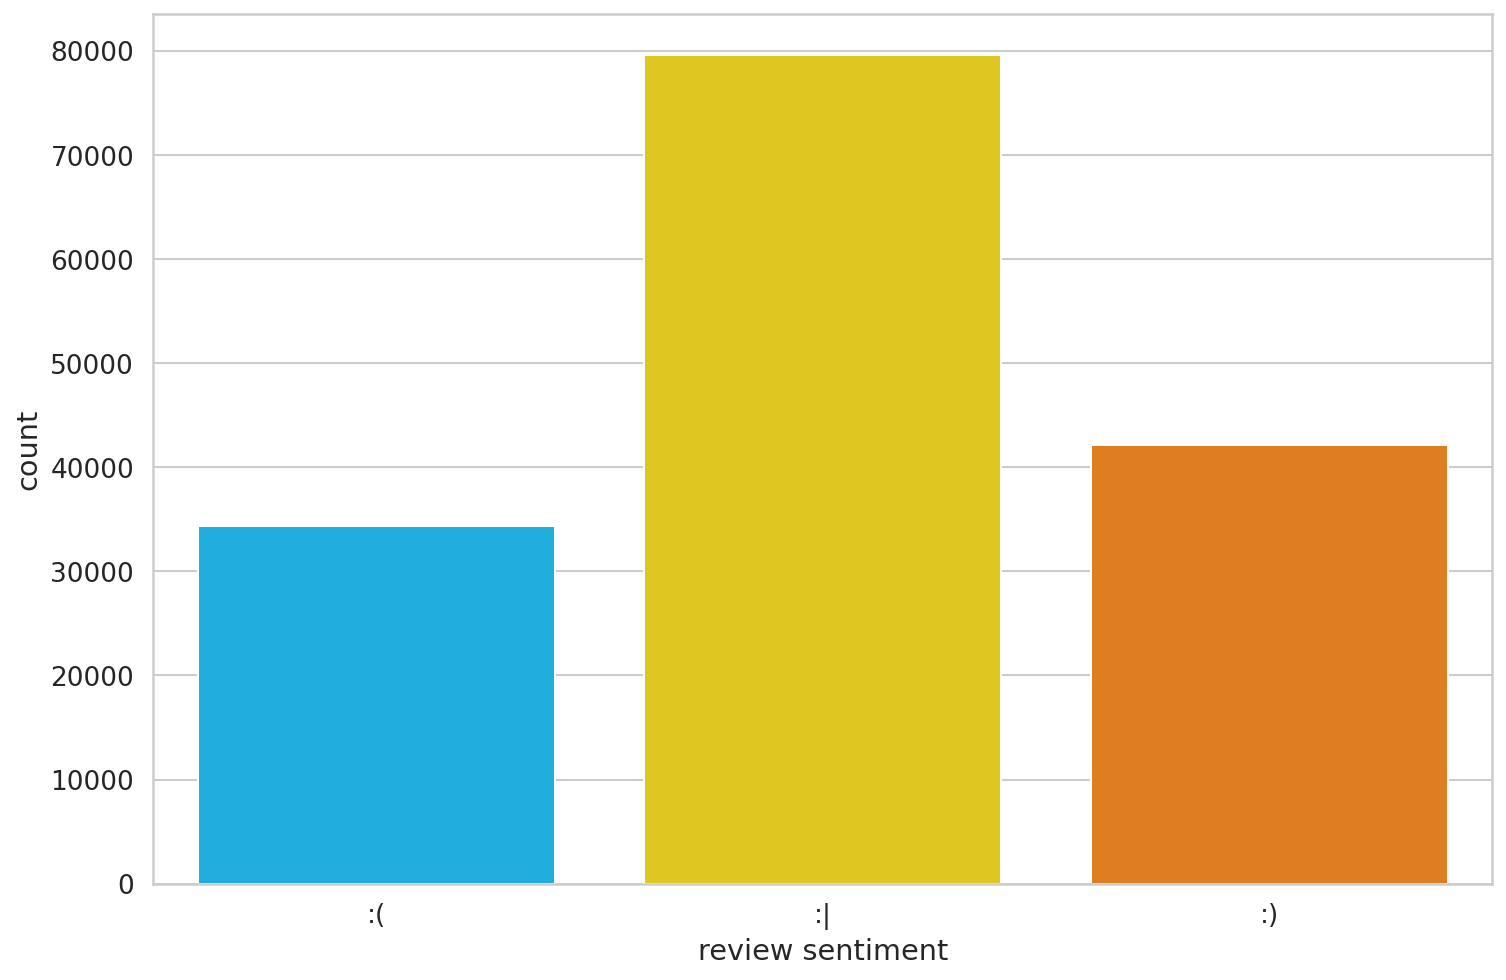

In [ ]:
ax = sns.countplot(df_train.Sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels([':(', ":|", ":)"]);

In [ ]:
df_train.Sentiment.value_counts()

1    79582
2    42133
0    34345
Name: Sentiment, dtype: int64

In [123]:
label0_count = 34345

df_0label = df_train.loc[df_train['Sentiment']==0]
df_1label = df_train.loc[df_train['Sentiment']==1]
df_2label = df_train.loc[df_train['Sentiment']==2]

print(df_0label.shape)
print(df_1label.shape)
print(df_2label.shape)

(34345, 4)
(79582, 4)
(42133, 4)


In [124]:
balanced_1label = df_1label.sample(label0_count)
balanced_2label = df_2label.sample(label0_count)
print(df_0label.shape, balanced_1label.shape, balanced_2label.shape)

(34345, 4) (34345, 4) (34345, 4)


In [125]:
balanced_1label.head(2)

,PhraseId,SentenceId,Phrase,Sentiment
121495,121496,6508,of the action,1
23082,23083,1045,in something that is improbable,1


In [126]:
balanced_2label.head(2)

,PhraseId,SentenceId,Phrase,Sentiment
61096,61097,3086,it would be nice to see what he could make wit...,2
36436,36437,1724,there are entertaining and audacious moments,2


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


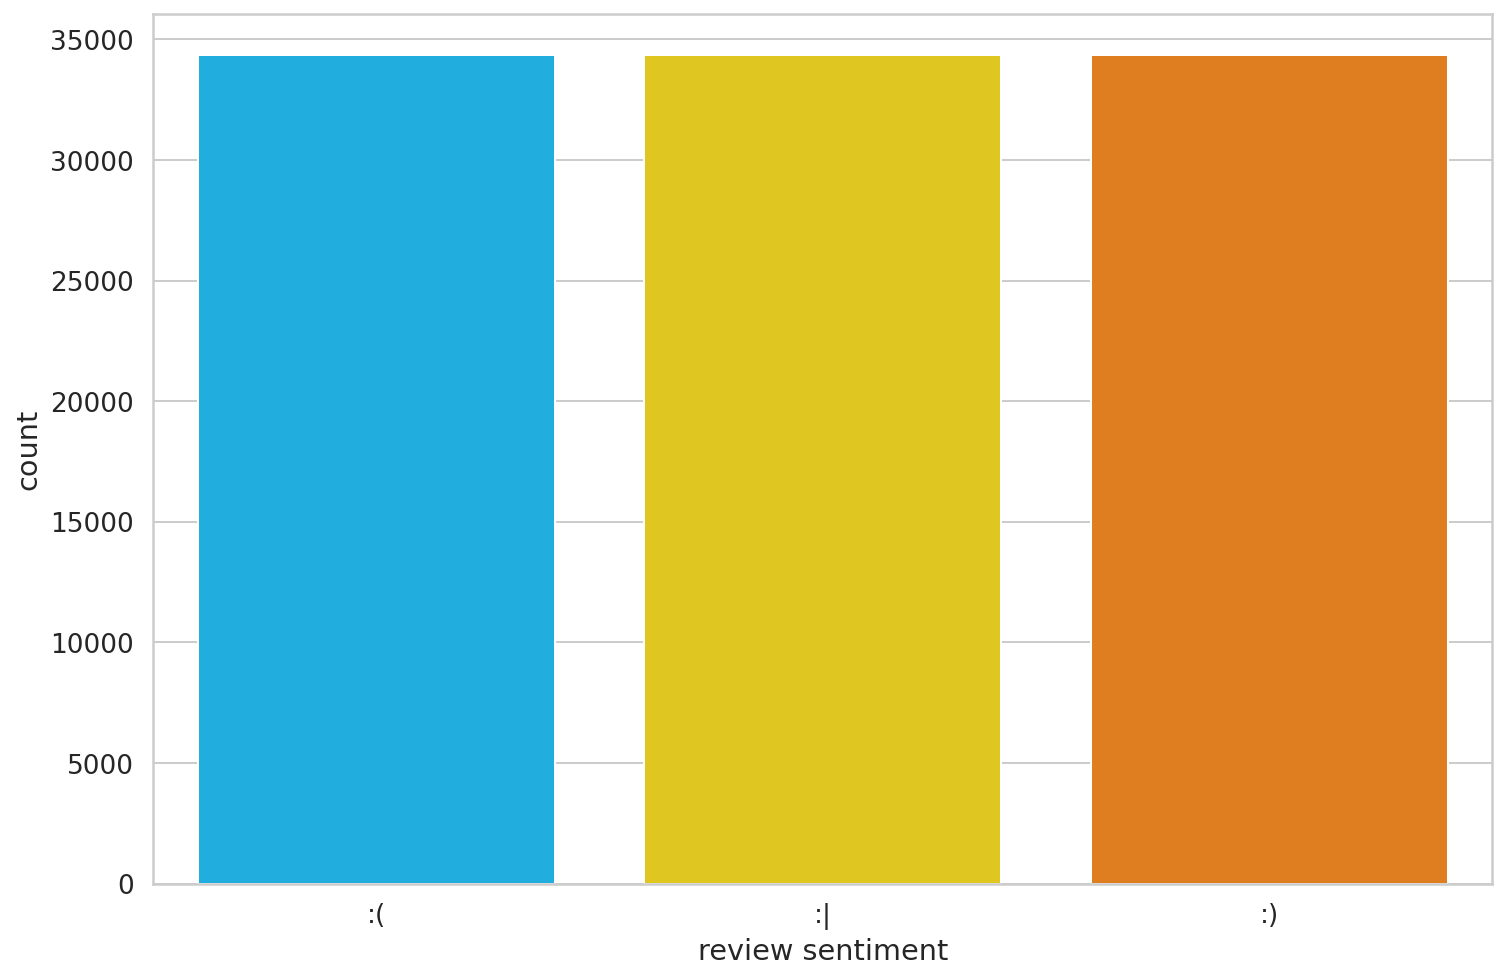

In [127]:
df_train = pd.concat([df_0label, balanced_1label, balanced_2label])
ax = sns.countplot(df_train['Sentiment'])
plt.xlabel('review sentiment')
ax.set_xticklabels([':(', ":|", ":)"]);

In [128]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_train.shape

(103035, 4)

## Data Preprocessing
**Sample test first**

In [129]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = "want to go roll around in the snow?"

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}') 

 Sentence: want to go roll around in the snow?
   Tokens: ['want', 'to', 'go', 'roll', 'around', 'in', 'the', 'snow', '?']
Token IDs: [1328, 1106, 1301, 5155, 1213, 1107, 1103, 4883, 136]


Special Tokens

In [ ]:
print("Ending: ", tokenizer.sep_token, tokenizer.sep_token_id)
print("Starting: ", tokenizer.cls_token, tokenizer.cls_token_id)
print("Padding: ", tokenizer.pad_token, tokenizer.pad_token_id)
print("Unknown- for everything else I guess: ", tokenizer.unk_token, tokenizer.unk_token_id)

Ending:  [SEP] 102
Starting:  [CLS] 101
Padding:  [PAD] 0
Unknown- for everything else I guess:  [UNK] 100


In [130]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [131]:
encoding['input_ids'].shape

torch.Size([1, 32])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'want',
 'to',
 'go',
 'roll',
 'around',
 'in',
 'the',
 'snow',
 '?',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
token_lens = []
all_text = pd.concat([df_train['Phrase'], df_test['Phrase']])
for txt in all_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


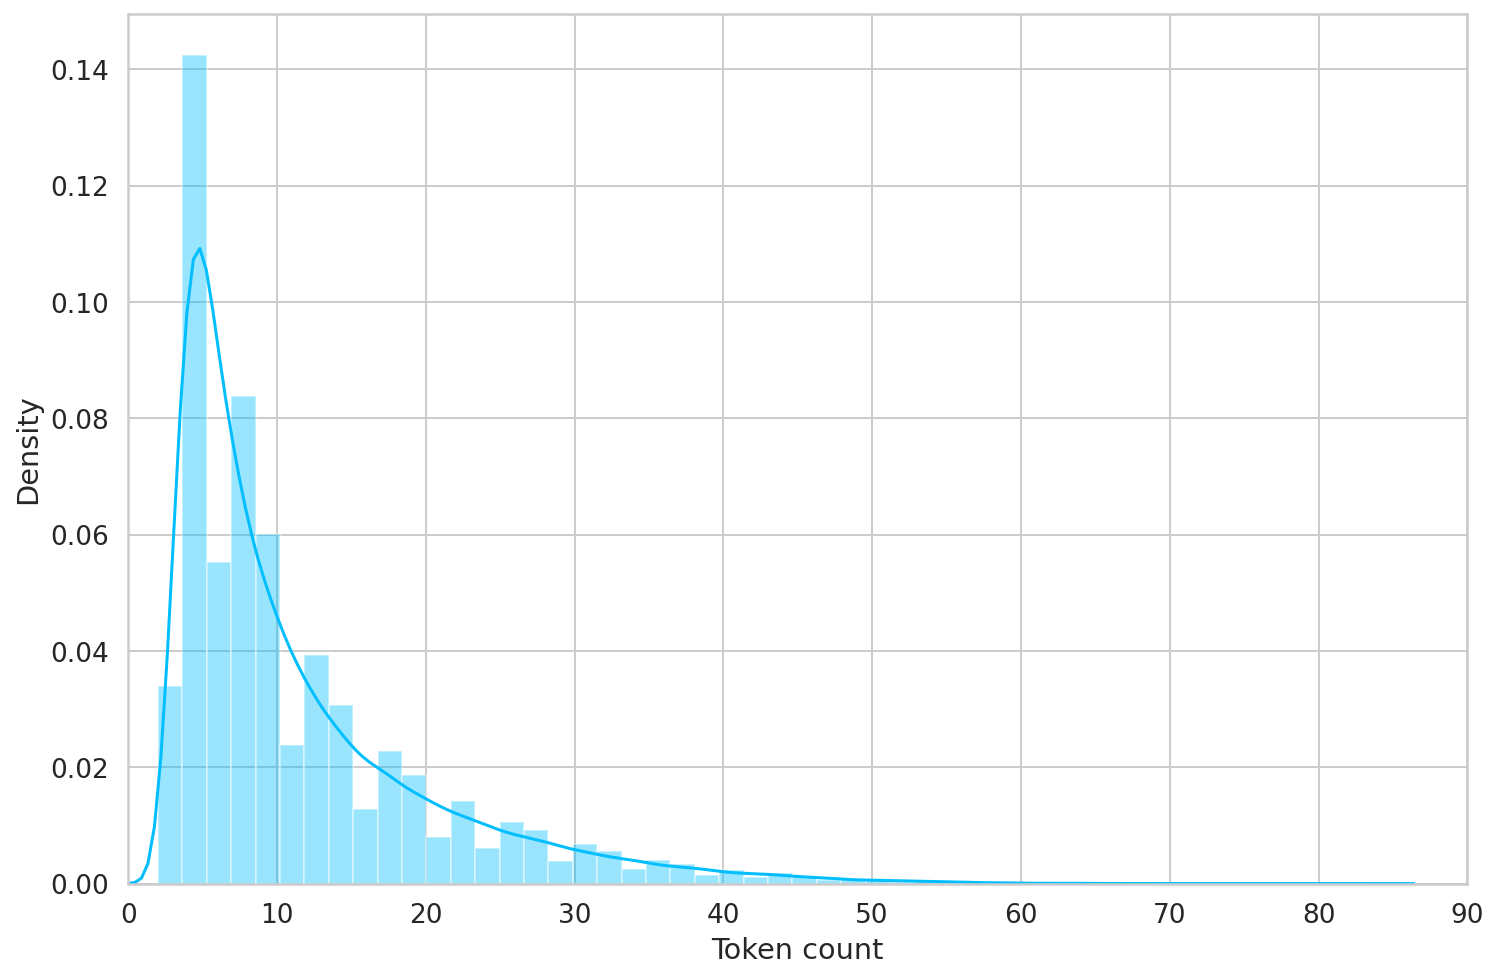

In [ ]:
sns.distplot(token_lens)
plt.xlim([0,90]);
plt.xlabel('Token count');

In [132]:
class RTDataset(Dataset):
  
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [133]:
# IMPORTANT VARIABLES HERE.
# prev --> 100, 32, 3
MAX_LEN = 100
BATCH_SIZE = 16
EPOCHS = 4

In [134]:
df_train.shape, df_test.shape

((103035, 4), (66292, 3))

In [135]:
# !! changed to only use training data 
df_train, df_test = train_test_split(df_train, test_size=0.2)
df_train, df_val = train_test_split(df_train, test_size=0.25)

In [120]:
df_train.shape, df_val.shape, df_test.shape

((156060, 4), (20607, 4), (66292, 3))

In [136]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  try:
    targets = df.Sentiment.to_numpy()
  except AttributeError:
    targets = np.array([0]* len(df))

  ds = RTDataset(
      reviews=df.Phrase.to_numpy(),
      targets=targets,
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

In [137]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


## BERT TIME

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
# Sample text from above
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
print(last_hidden_state.shape)
print(bert_model.config.hidden_size)
print(pooled_output.shape)

torch.Size([1, 32, 768])
768
torch.Size([1, 768])


In [138]:
# different from the resource. Doing softmax inside (like video) (21:39)
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    # return self.softmax(output)
    return output

In [139]:
device

device(type='cuda', index=0)

In [140]:
!nvidia-smi

Fri Nov  6 07:22:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |   8425MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Sample run a batch

In [ ]:
class_names = [':(', ':/', ':)']
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
# data is one batch, assigned above
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape, attention_mask.shape)

torch.Size([16, 100]) torch.Size([16, 100])


In [ ]:
out = model(input_ids, attention_mask)
print(out.shape)
out

torch.Size([16, 3])


tensor([[ 0.7178, -0.1043,  0.7436],
        [ 0.3241, -0.7374,  0.0105],
        [ 0.2400, -0.1371,  0.9491],
        [ 0.7575, -0.6056,  0.4018],
        [ 0.8341, -0.4295, -0.1027],
        [ 0.1160, -0.6957,  0.5554],
        [ 0.5114, -0.8027,  0.5997],
        [ 0.1243, -0.3433,  0.4681],
        [ 0.3891, -0.3385,  0.7847],
        [ 0.0976, -0.0702,  0.7986],
        [ 0.3846, -0.5547,  0.3963],
        [ 0.7526,  0.1006,  0.6792],
        [ 0.6869, -1.4217,  0.1538],
        [ 0.2634, -0.9486, -0.0349],
        [ 0.5856, -0.1528,  0.6311],
        [ 0.3113, -0.2919,  0.4911]], device='cuda:0', grad_fn=<AddmmBackward>)

### Training

In [ ]:
EPOCHS

4

In [ ]:
len(train_data_loader)

3864

In [141]:
# AdamW optimizer, linear scheduler with no warmup steps
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Recommended Hyper Parameters
- Batch size: 16, 32 --> Will do 32 for reduced training time. I think we have sufficient enough data to do so
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [142]:
def train_epoch (model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    # preds | preds.indices
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
preds = torch.max(out, dim=1)
print(len(preds))
preds

2


torch.return_types.max(values=tensor([0.7436, 0.3241, 0.9491, 0.7575, 0.8341, 0.5554, 0.5997, 0.4681, 0.7847,
        0.7986, 0.3963, 0.7526, 0.6869, 0.2634, 0.6311, 0.4911],
       device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2], device='cuda:0'))

In [ ]:
print(preds.indices)
print(data['targets'])

tensor([2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2], device='cuda:0')
tensor([1, 2, 0, 1, 0, 0, 2, 0, 2, 0, 1, 2, 1, 1, 0, 1])


In [143]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in tqdm(data_loader):
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      # pred.indicies
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

    return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

  0%|          | 0/3864 [00:00<?, ?it/s]

Epoch 1/4
----------


  0%|          | 0/1288 [00:00<?, ?it/s]

Train loss 0.6564626952317036 accuracy 0.733601850503874


100%|██████████| 1288/1288 [02:06<00:00, 10.20it/s]


Val   loss 0.5944616147461608 accuracy 0.7691561120007765



  0%|          | 0/3864 [00:00<?, ?it/s]

Epoch 2/4
----------


  0%|          | 0/1288 [00:00<?, ?it/s]

Train loss 0.4720858823513809 accuracy 0.8180391776257259


100%|██████████| 1288/1288 [02:06<00:00, 10.16it/s]


Val   loss 0.6210375257785091 accuracy 0.7743970495462708



  0%|          | 0/3864 [00:00<?, ?it/s]

Epoch 3/4
----------


  0%|          | 0/1288 [00:00<?, ?it/s]

Train loss 0.36978183728575276 accuracy 0.8663075653904012


  0%|          | 0/3864 [00:00<?, ?it/s]

Val   loss 0.6866312921206288 accuracy 0.7681855680108701

Epoch 4/4
----------


  0%|          | 0/1288 [00:00<?, ?it/s]

Train loss 0.3020189220520068 accuracy 0.8961356173468562


100%|██████████| 1288/1288 [02:06<00:00, 10.21it/s]

Val   loss 0.774434211231502 accuracy 0.7689134760032998

CPU times: user 55min, sys: 28min 40s, total: 1h 23min 40s
Wall time: 1h 25min 2s


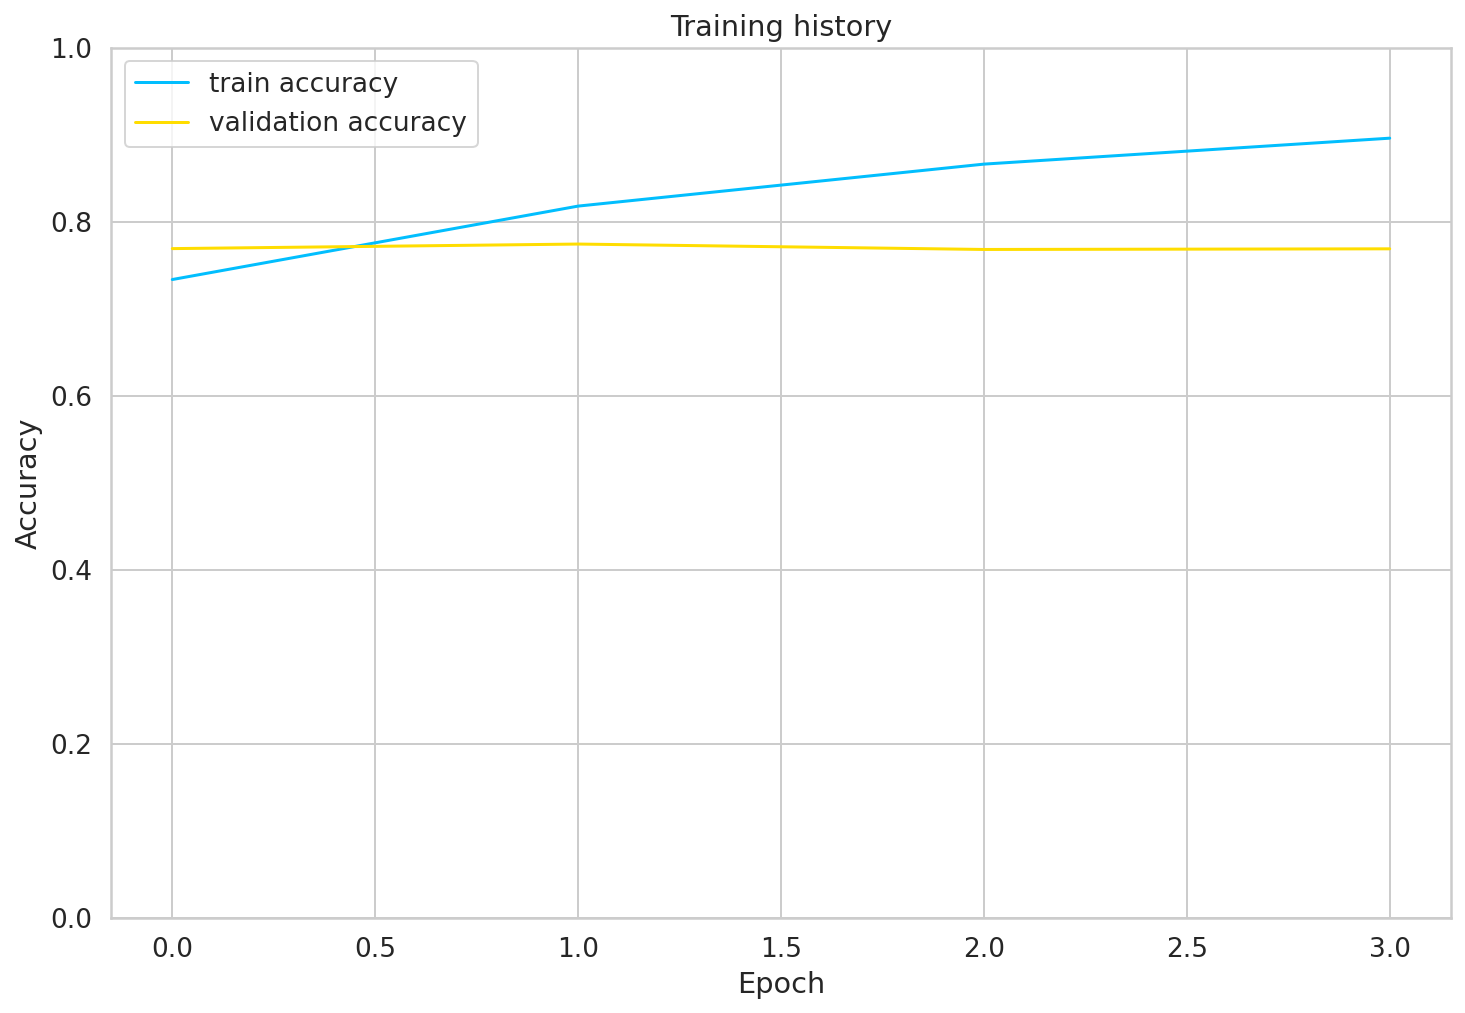

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
history['train_acc']

[tensor(0.7336, device='cuda:0', dtype=torch.float64),
 tensor(0.8180, device='cuda:0', dtype=torch.float64),
 tensor(0.8663, device='cuda:0', dtype=torch.float64),
 tensor(0.8961, device='cuda:0', dtype=torch.float64)]

In [ ]:
history['val_acc']

[tensor(0.7692, device='cuda:0', dtype=torch.float64),
 tensor(0.7744, device='cuda:0', dtype=torch.float64),
 tensor(0.7682, device='cuda:0', dtype=torch.float64),
 tensor(0.7689, device='cuda:0', dtype=torch.float64)]

**batch, lr, epoch, dropout = 32, 2e-5, 3, 0.3** <br/>
**batch, lr, epoch, dropout = 16, 2e-5, 4, 0.3**
- [tensor(0.7336, device='cuda:0', dtype=torch.float64),
 tensor(0.8180, device='cuda:0', dtype=torch.float64),
 tensor(0.8663, device='cuda:0', dtype=torch.float64),
 tensor(0.8961, device='cuda:0', dtype=torch.float64)]
- [tensor(0.7692, device='cuda:0', dtype=torch.float64),
 tensor(0.7744, device='cuda:0', dtype=torch.float64),
 tensor(0.7682, device='cuda:0', dtype=torch.float64),
 tensor(0.7689, device='cuda:0', dtype=torch.float64)]



## Evaluation

In [144]:
model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [145]:
model = model.to(device)

In [146]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

100%|██████████| 1288/1288 [02:08<00:00, 10.04it/s]


0.8185568010870093

## Raw Text

In [148]:
def review_text(text, model, tokenizer, MAX_LEN):

  encoded_review = tokenizer.encode_plus(
      text,
      max_length = MAX_LEN,
      add_special_tokens=True,
      padding='max_length',
      return_token_type_ids=False,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  return prediction

In [152]:
text = "I'd say its okay don't you think? its fine. eh"

In [153]:
print(f'Review text: {text}')
print(f'Sentiment: {class_names[review_text(text, model, tokenizer, MAX_LEN)]}')

Review text: I'd say its okay don't you think? its fine. eh
Sentiment: :/
